In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import statsmodels as sm 
%matplotlib inline

In [3]:
data = pd.read_table(r"C:\Users\86187\Desktop\CUHKSZ\MAT2040\projects\project2\data\Part2_training_data.txt", names=["Product_%s" % i for i in range(1, 6)], sep=" ")
print(data.head())
data.describe()

      Product_1    Product_2    Product_3    Product_4     Product_5
0  10432.355471  1311.050793  5995.892953  6898.728676  14797.156248
1  12572.545878  1178.080301  4965.946985  6927.028821  10860.914744
2  10381.966493  1112.632737  5204.199532  6880.382309  10023.963464
3  12730.497385  1048.444761  5003.335886  6991.345922  10943.233287
4  11311.268512  1443.064178  5568.939445  6716.246451  13469.202432


,Product_1,Product_2,Product_3,Product_4,Product_5
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,8004.855299,8915.541477,6217.253048,942.864326,1867.278843
std,12500.552447,5189.546884,3662.307092,1594.828692,2480.226241
min,-14892.670793,-76.340834,-3230.763880,-3320.819082,-3968.474206
25%,-3215.758442,5482.545611,3483.624109,-50.969737,132.809356
50%,9171.882908,7799.490947,6217.671975,852.229134,1740.507044
75%,17586.676312,11421.713448,9279.459348,1911.739349,3272.914631
max,36305.548357,24922.924648,14852.961991,7945.895794,14797.156248


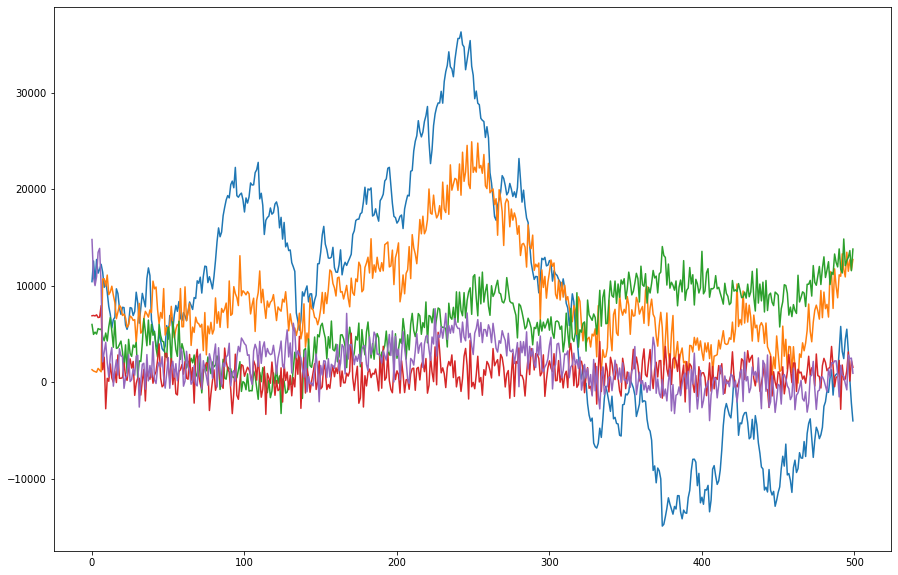

In [4]:
plt.figure(figsize=(15,10))
plt.plot(data)
# plt.legend(loc="best")
plt.show()

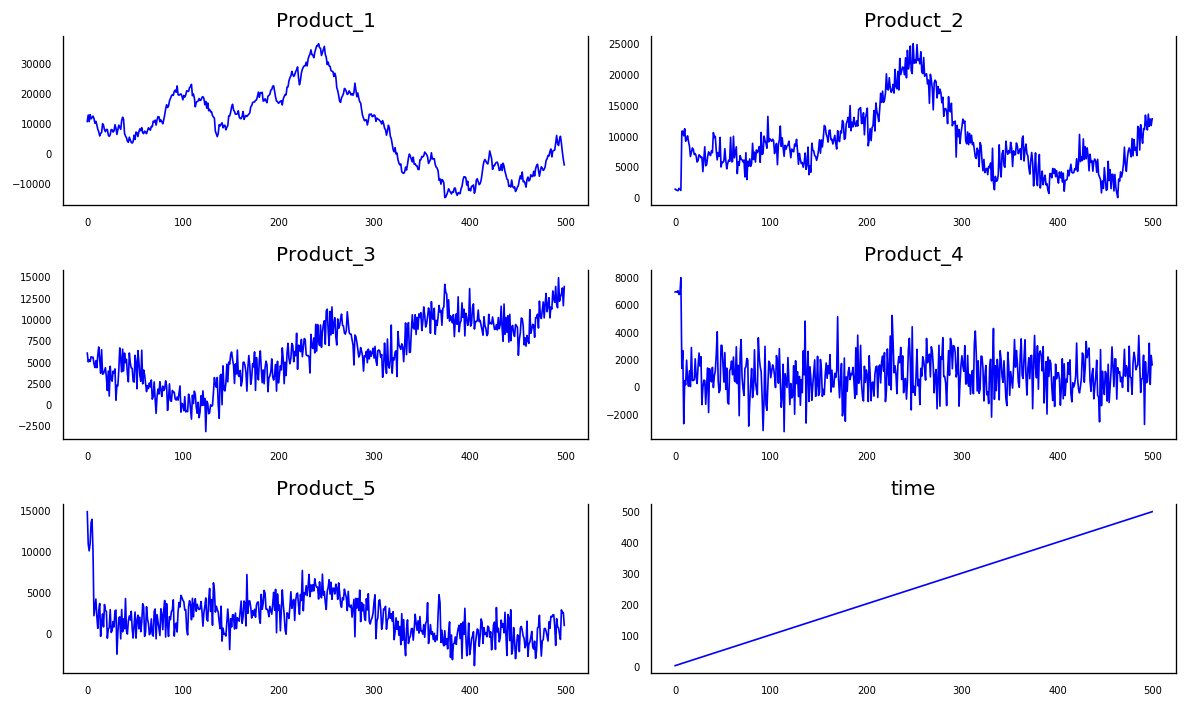

In [5]:
data["time"] = np.arange(0, 500)
fig, ax = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for col, ax in enumerate(ax.flatten()):
    col_data = data[data.columns[col]]
    ax.plot(col_data, color="blue", linewidth=1)
    ax.set_title(data.columns[col])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

In [6]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [7]:
# Check correlation between each time series by Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 165
def granger_causation_matrix(data, variables, test="ssr_chi2test", verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables) # Generate Test Matrix
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row, col]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {row}, X = {col}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[row, col] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

matrix = granger_causation_matrix(data.loc[:,data.columns!='time'], data.columns[data.columns!="time"])
print(matrix)
"The p-values are small enough to reject the null hypo of zero correlation between time series"

             Product_1_x  Product_2_x  Product_3_x  Product_4_x  Product_5_x
Product_1_y          1.0          0.0          0.0          0.0          0.0
Product_2_y          0.0          1.0          0.0          0.0          0.0
Product_3_y          0.0          0.0          1.0          0.0          0.0
Product_4_y          0.0          0.0          0.0          1.0          0.0
Product_5_y          0.0          0.0          0.0          0.0          1.0


'The p-values are small enough to reject the null hypo of zero correlation between time series'

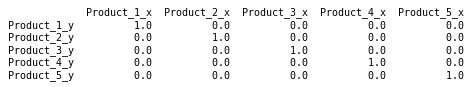

In [30]:
plt.rc('figure', figsize=(1, 1))
plt.text(0.01, 0.05, str(matrix), {'fontsize':12}, fontproperties='monospace')
plt.axis('off')
plt.tight_layout()

In [9]:
# Cointegration Test: If two or more time series are cointegrated, they have statistically significant relationship in the long run
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05):
    output = coint_johansen(df, -1, 5)
    d = {"0.90": 0, "0.95": 1, "0.99": 2}
    traces = output.lr1
    cvts = output.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6): return str(val).ljust(length)
    print("Name   ::   Test Stat > C(95%)   => Signif  \n", '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), "::", adjust(round(trace,2), 9), ">", adjust(cvt, 8), "=>", trace>cvt)

cointegration_test(data.loc[:, data.columns!="time"])

Name   ::   Test Stat > C(95%)   => Signif  
 ----------------------------------------
Product_1 :: 374.45    > 60.0627  => True
Product_2 :: 186.69    > 40.1749  => True
Product_3 :: 77.95     > 24.2761  => True
Product_4 :: 1.91      > 12.3212  => False
Product_5 :: 0.08      > 4.1296   => False


In [10]:
# Check for stationary 
def adfuller_test(series, signif=0.05, name="", verbose=False):
    r = adfuller(series, autolag="AIC")
    output = {'test-statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags': round(r[2], 4), "n_obs": r[3]}
    p_value = output["pvalue"]
    def adjust(val, length=6): return str(val).ljust(length)

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", "-"*47)
    print(f" Null Hypothesis: Data has unit root. Non-stationary")
    print(f" Significance level    = {signif}")
    print(f" Test Statistic        = {output['test-statistic']}")
    print(f" No. Lags Chosen       = {output['n_lags']}")

    for key, val in r[4].items():
        print(f" Critical value {adjust(key)} = {round(val, 3)}")
    
    if p_value <= signif:
        print(f" => P-value = {p_value}. Rejecting Null Hypothesis")
        print(f" => Series is Stationary")
    else:
        print(f" => P-value = {p_value}. Weak evidence to reject the Null Hypothesis")
        print(f" => Series is Non-stationary")

In [11]:
for name, column in data.loc[:, data.columns!="time"].iteritems():
    adfuller_test(column, name=name)
    print('\n')

    Augmented Dickey-Fuller Test on "Product_1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-stationary
 Significance level    = 0.05
 Test Statistic        = -1.0718
 No. Lags Chosen       = 0
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-value = 0.7262. Weak evidence to reject the Null Hypothesis
 => Series is Non-stationary


    Augmented Dickey-Fuller Test on "Product_2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-stationary
 Significance level    = 0.05
 Test Statistic        = -1.9789
 No. Lags Chosen       = 3
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-value = 0.2959. Weak evidence to reject the Null Hypothesis
 => Series is Non-stationary


    Augmented Dickey-Fuller Test on "Product_3" 
    -----------------------------------------------
 Null Hypothesis: Data has 

In [12]:
data_1st_difference = data.loc[:, data.columns!="time"].diff().dropna()
data_1st_difference.tail()

,Product_1,Product_2,Product_3,Product_4,Product_5
495,1070.659134,2561.722862,539.785174,859.466932,-649.791727
496,-2294.363545,-1975.131504,324.478097,1946.543452,3606.477142
497,-2925.011473,1183.745673,700.642461,-3016.345135,-390.293196
498,-2437.460296,-1063.089736,-2087.132861,2122.350525,74.503042
499,-1843.644785,1099.168928,2244.710565,-688.371631,-1573.046546


In [13]:
for name, column in data_1st_difference.iteritems():
    adfuller_test(column, name=name)
    print("\n")

    Augmented Dickey-Fuller Test on "Product_1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-stationary
 Significance level    = 0.05
 Test Statistic        = -21.861
 No. Lags Chosen       = 0
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-value = 0.0. Rejecting Null Hypothesis
 => Series is Stationary


    Augmented Dickey-Fuller Test on "Product_2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-stationary
 Significance level    = 0.05
 Test Statistic        = -20.1845
 No. Lags Chosen       = 2
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-value = 0.0. Rejecting Null Hypothesis
 => Series is Stationary


    Augmented Dickey-Fuller Test on "Product_3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-stationary
 Significance level    

In [14]:
# Select the Order(p) for the VAR model
model = VAR(data_1st_difference)
standard = {
    'Lag Order':[],
    'AIC':[],
    'BIC':[],
    'FPE':[],
    'HQIC':[],
}
for i in range(1, 80):
    res = model.fit(i)
    print('Lag Order = ', i)
    print('AIC: ', res.aic)
    print('BIC: ', res.bic)
    print('FPE: ', res.fpe)
    print('HQIC:', res.hqic, '\n')
    standard['Lag Order'].append(i)
    standard['AIC'].append(res.aic)
    standard['BIC'].append(res.bic)
    standard['FPE'].append(res.fpe)
    standard['HQIC'].append(res.hqic)

C:\Users\86187\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
Lag Order =  1
AIC:  74.20466495273163
BIC:  74.45831555978131
FPE:  1.6853071079477217e+32
HQIC: 74.30421405177233 

Lag Order =  2
AIC:  73.77242143985532
BIC:  74.23816077875938
FPE:  1.0938839443845512e+32
HQIC: 73.95522369405069 

Lag Order =  3
AIC:  73.55696030687729
BIC:  74.23544029505872
FPE:  8.81922841225686e+31
HQIC: 73.82328590794813 

Lag Order =  4
AIC:  73.54794160581845
BIC:  74.43981749484817
FPE:  8.741296483093757e+31
HQIC: 73.89806215217166 

Lag Order =  5
AIC:  73.53033712015221
BIC:  74.63626751941219
FPE:  8.59074985516772e+31
HQIC: 73.9645256269086 

Lag Order =  6
AIC:  73.5197906452918
BIC:  74.8404375458529
FPE:  8.503547958059506e+31
HQIC: 74.03832155440463 

Lag Order =  7
AIC:  73.32677445476158
BIC:  74.86280325347828
FPE:  7.014269

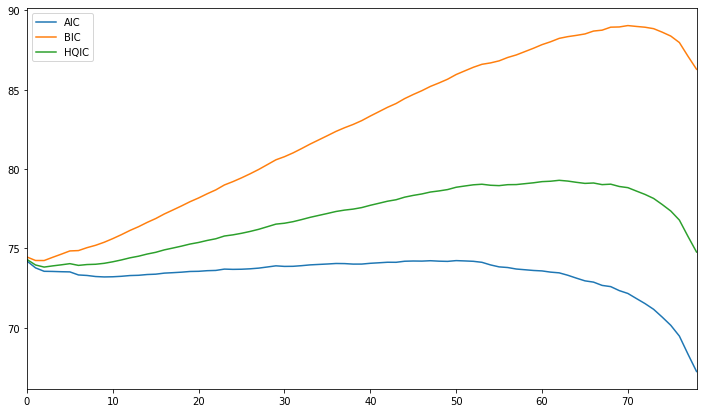

In [15]:
standard = pd.DataFrame(standard)
standard.loc[:,standard.columns[~standard.columns.isin(['Lag Order', "FPE"])]].plot()
plt.show()

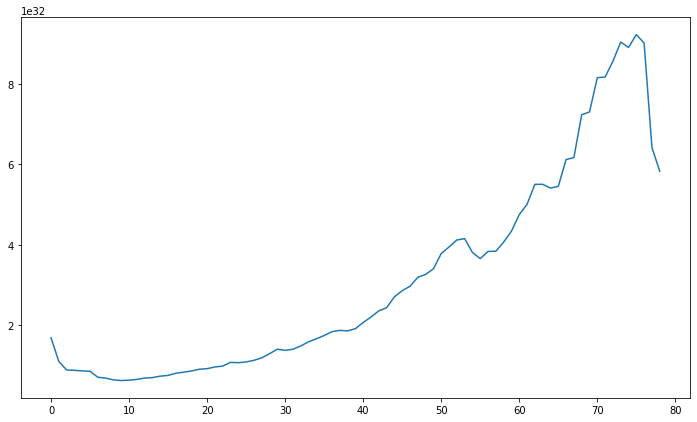

In [16]:
plt.plot(standard["FPE"])
plt.show()

In [17]:
print("The Lag Order that gives the least BIC is ", standard["BIC"].argmin())
print("The Lag Order that gives the least AIC is ", standard["AIC"].argmin())
print("The Lag Order that gives the least HQIC is", standard["HQIC"].argmin())
print("The Lag Order that gives the least FPE is", standard["FPE"].argmin())

The Lag Order that gives the least BIC is  2
The Lag Order that gives the least AIC is  78
The Lag Order that gives the least HQIC is 2
The Lag Order that gives the least FPE is 9


In [18]:
Lag_order = model.select_order(maxlags=80)
Lag_order.summary()

,AIC,BIC,FPE,HQIC
0,75.22,75.27,4.640e+32,75.24
1,74.13,74.41,1.556e+32,74.24
2,73.64,74.17,9.576e+31,73.85
3,73.39,74.16*,7.489e+31,73.70
4,73.39,74.40,7.450e+31,73.79
5,73.34,74.59,7.103e+31,73.84
6,73.28,74.78,6.707e+31,73.87
7,73.23,74.96,6.345e+31,73.91
8,73.22,75.20,6.327e+31*,74.00
9,73.24,75.46,6.477e+31,74.12


In [19]:
model_fitted = model.fit(78)
model_fitted.summary()

 0.612432           -2.266           0.023
L31.Product_1         0.221534         0.228523            0.969           0.332
L31.Product_2        -0.334983         0.406337           -0.824           0.410
L31.Product_3         0.568143         0.465043            1.222           0.222
L31.Product_4         0.044995         0.610025            0.074           0.941
L31.Product_5        -0.968431         0.626576           -1.546           0.122
L32.Product_1         0.293884         0.232159            1.266           0.206
L32.Product_2        -0.155407         0.418752           -0.371           0.711
L32.Product_3         0.436064         0.450768            0.967           0.333
L32.Product_4         0.061209         0.581173            0.105           0.916
L32.Product_5        -1.463311         0.646972           -2.262           0.024
L33.Product_1         0.405925         0.234230            1.733           0.083
L33.Product_2        -0.217908         0.421205           -0.517  

In [20]:
test_data = pd.read_csv(r"C:\Users\86187\Desktop\CUHKSZ\MAT2040\projects\project2\data\Part2_testing_data.txt", names=["Product_%s" % i for i in range(1,6)], sep=" ")
test_data["time"] = np.arange(500, 700)
test_data = test_data.set_index("time")
print(test_data.head())
print(test_data.describe())

        Product_1     Product_2     Product_3    Product_4    Product_5
time                                                                   
500  -6112.909507  11479.297609  12410.010943  3810.140731   759.584826
501  -6453.754458   7623.905929  13983.120428   298.772478  3897.468626
502  -6984.089166  11796.894684  14776.252776  3162.651622  1081.526686
503  -6370.257156   9920.477217  12383.423371  -562.601683  -654.084572
504  -7461.136781  10021.633574  12196.650132  1975.851926  1206.729201
          Product_1     Product_2     Product_3    Product_4    Product_5
count    200.000000    200.000000    200.000000   200.000000   200.000000
mean   -7075.446264  13970.506024  19958.852676  2178.374221   839.922235
std     5491.134476   5009.471751   4523.185399  1555.237177  1710.498694
min   -20114.913687   5349.322325  12196.650132 -1586.019632 -3623.368383
25%   -10232.398441  10318.447774  16150.111819  1179.691384  -328.226679
50%    -6173.783978  12397.713409  19127.589922  229

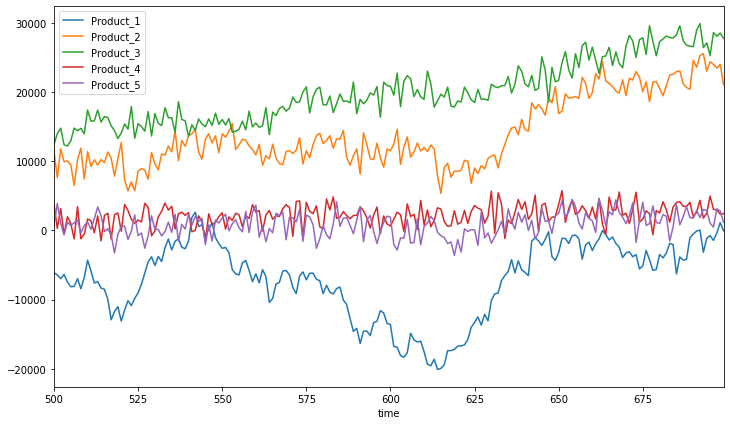

In [21]:
test_data.plot()
plt.show()

In [22]:
test_difference = test_data.diff().dropna()
test_difference.head()

,Product_1,Product_2,Product_3,Product_4,Product_5
time,,,,,
501,-340.844951,-3855.391680,1573.109486,-3511.368254,3137.883799
502,-530.334708,4172.988756,793.132347,2863.879144,-2815.941940
503,613.832009,-1876.417468,-2392.829405,-3725.253305,-1735.611258
504,-1090.879624,101.156357,-186.773239,2538.453609,1860.813773
505,-688.339279,-557.590180,731.834593,-938.790876,-500.628230


In [23]:
lag_order = model_fitted.k_ar
fc_input = data_1st_difference.values[-lag_order:]
fc = model_fitted.forecast(y=fc_input, steps=200)
fc_dataframe = pd.DataFrame(fc, columns=data_1st_difference.columns+"_1d", index=np.arange(500, 700))
fc_dataframe.head()

,Product_1_1d,Product_2_1d,Product_3_1d,Product_4_1d,Product_5_1d
500,-5516.718210,1792.899038,4589.285660,6530.362071,-11564.442856
501,-2183.328110,-3544.113935,-4403.765164,2756.828969,5236.788907
502,6021.095519,-8791.686628,6762.765022,-13100.525712,6603.007298
503,5611.638584,5421.851213,-1704.167870,11369.475104,-2271.743815
504,4924.187275,4717.570797,-4372.429936,-8513.452918,7991.289337


In [24]:
def invert_trans(df_train, df_fc):
    df_forecast = pd.DataFrame()
    columns = df_train.columns
    for col in columns:
        df_forecast[str(col)+"_forecast"] = df_train[col].iloc[-1] + df_fc[str(col)+"_1d"].cumsum()
    return df_forecast
df_results = invert_trans(data.loc[:,data.columns!="time"], fc_dataframe)
df_results.head()

,Product_1_forecast,Product_2_forecast,Product_3_forecast,Product_4_forecast,Product_5_forecast
500,-9508.924889,14518.784429,18398.030856,8097.272138,-10625.237159
501,-11692.252999,10974.670494,13994.265693,10854.101107,-5388.448252
502,-5671.157480,2182.983866,20757.030715,-2246.424606,1214.559046
503,-59.518896,7604.835079,19052.862845,9123.050498,-1057.184769
504,4864.668379,12322.405876,14680.432909,609.597581,6934.104568


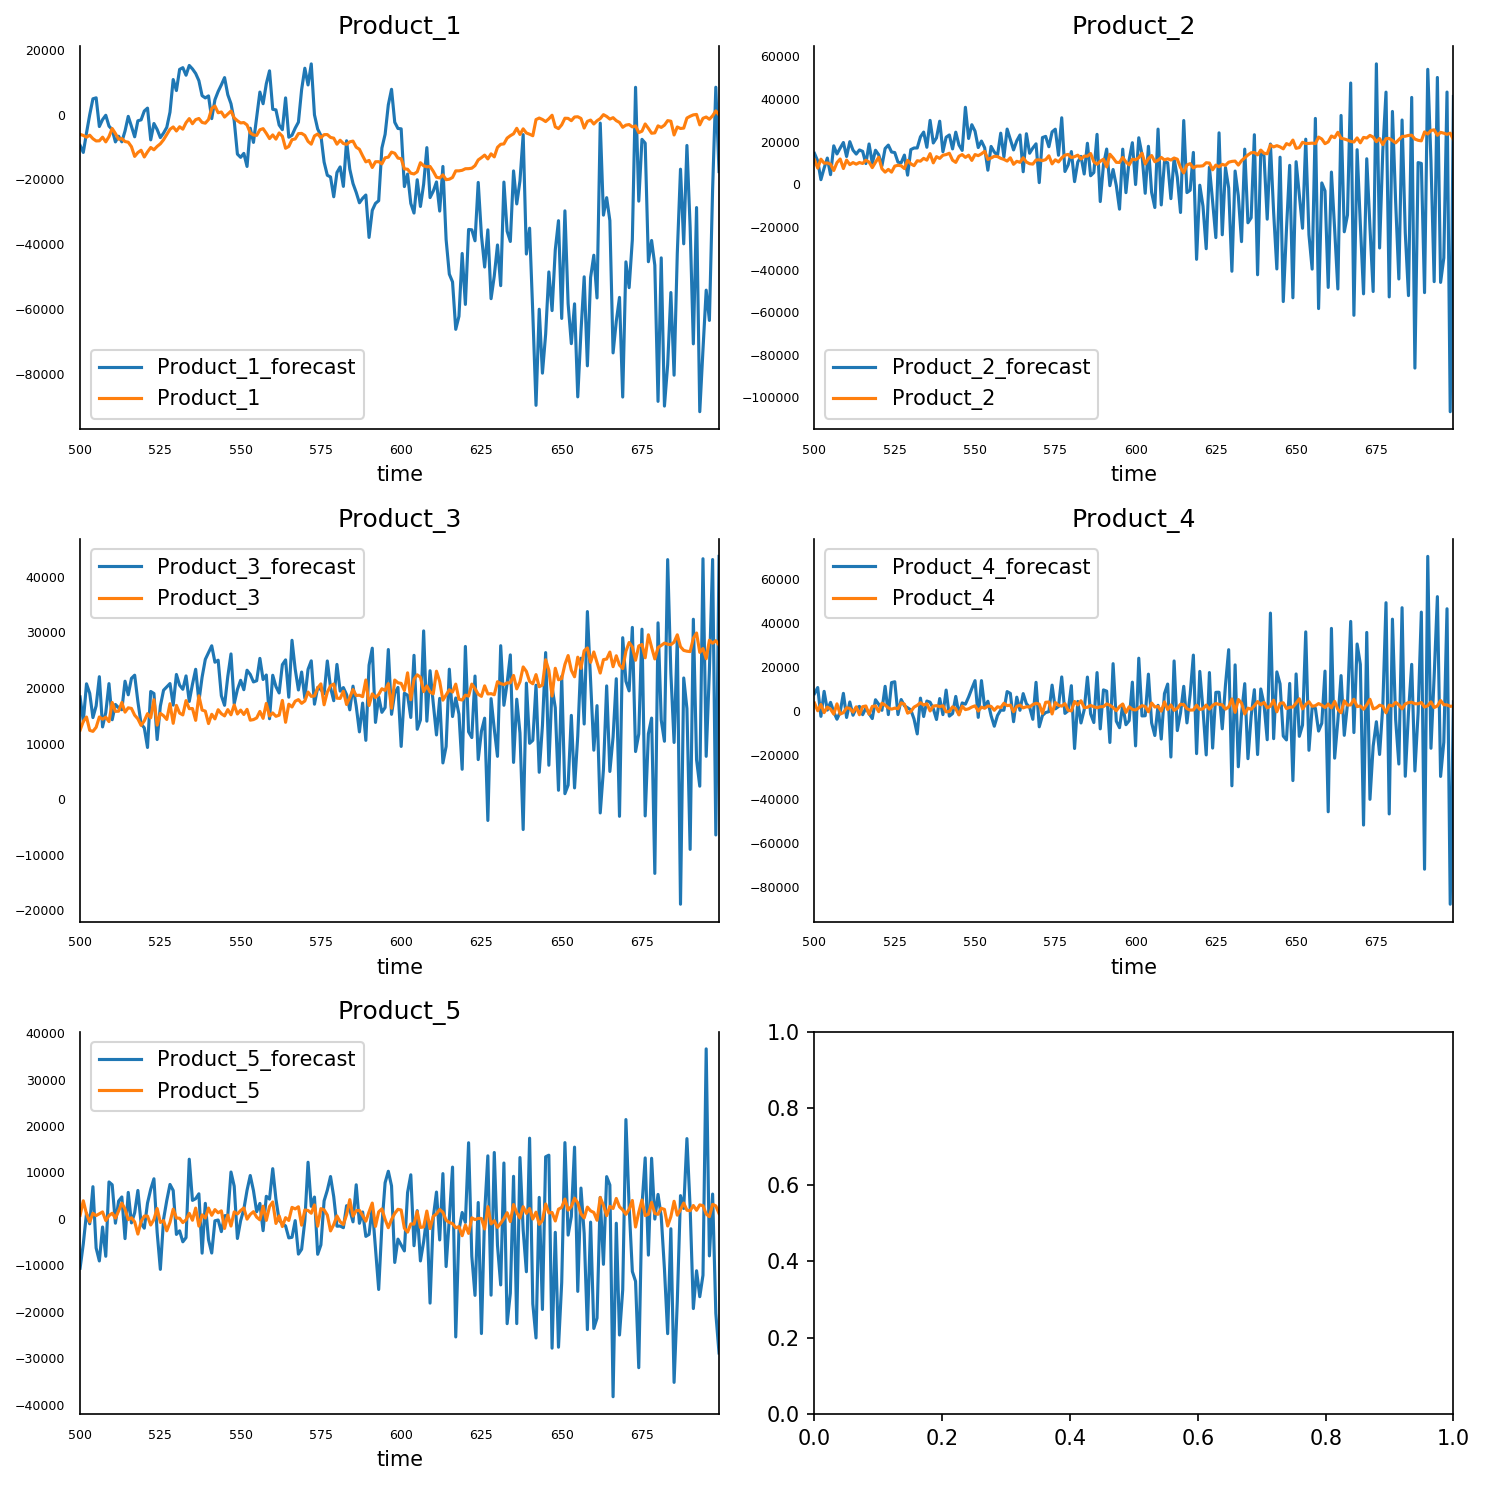

In [25]:
fig, ax = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10, 10))
for i, (col, ax) in enumerate(zip(data.loc[:,data.columns!="time"].columns, ax.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    test_data[col].plot(legend=True, ax=ax)
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [26]:
from sklearn.metrics import mean_squared_error
import math
RMSE = dict()
for col in data.loc[:,data.columns!="time"]:
    RMSE[col+"_RMSE"] = math.sqrt(mean_squared_error(test_data[col], df_results[col+"_forecast"]))
RMSE

{'Product_1_RMSE': 31976.980883723056,
 'Product_2_RMSE': 29334.36012630151,
 'Product_3_RMSE': 10965.563702961275,
 'Product_4_RMSE': 19445.44243437039,
 'Product_5_RMSE': 11770.881628593599}